In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('RandomForest').getOrCreate()


In [4]:
df = spark.read.load("./finalEdited-HumanHappiness-BDAS-mining.csv", format="csv", header=True, inferSchema=True)

In [5]:
# Decision Tree Regression

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [11]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
vector_assembler = VectorAssembler(
    inputCols=['Year',
 'Rule of Law',
 'Disappearances, Conflicts, and Terrorism',
 'Women Security & Safety',
 'Security & Safety',
 'Women Movement',
 'Movement',
 'Legal and Regulatory Restrictions',
 'State Control over Internet Access',
 'Expression & Information',
 'Same Sex Relationships',
 'Divorce',
 'PERSONAL FREEDOM (Score)',
 'PERSONAL FREEDOM (Rank)',
 'Government  enterprises and investment',
 'Top marginal income tax rate',
 'Legal enforcement of contracts',
 'Reliability of police',
 'Gender Legal Rights Adjustment',
 'Money growth',
 'Inflation: Most recent year',
 'Compliance costs of importing and exporting',
 'Regulatory trade barriers',
 'Foreign ownership/investment restrictions',
 'Freedom to trade internationally',
 'Hiring regulations and minimum wage',
 'Labour market regulations',
 'Licensing restrictions',
 'Business regulations',
 'ECONOMIC FREEDOM (Score)',
 'ECONOMIC FREEDOM (Rank)'],
    outputCol="features")

In [12]:
vector_output = vector_assembler.transform(df)

In [13]:
vector_output.printSchema()
vector_output.head(1)

root
 |-- Year: integer (nullable = true)
 |-- Countries: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- HUMAN FREEDOM (Score): double (nullable = true)
 |-- HUMAN FREEDOM (Rank): integer (nullable = true)
 |-- HUMAN FREEDOM (Quartile): integer (nullable = true)
 |-- Rule of Law: double (nullable = true)
 |-- Disappearances, Conflicts, and Terrorism: double (nullable = true)
 |-- Women Security & Safety: double (nullable = true)
 |-- Security & Safety: double (nullable = true)
 |-- Women Movement: double (nullable = true)
 |-- Movement: double (nullable = true)
 |-- Legal and Regulatory Restrictions: double (nullable = true)
 |-- State Control over Internet Access: double (nullable = true)
 |-- Expression & Information: double (nullable = true)
 |-- Same Sex Relationships: integer (nullable = true)
 |-- Divorce: double (nullable = true)
 |-- PERSONAL FREEDOM (Score): double (nullable = true)
 |-- PERSONAL FREEDOM (Rank): integer (nullable = true)
 |-- Government  e

[Row(Year=2017, Countries='Albania', Region='Eastern Europe', HUMAN FREEDOM (Score)=7.84, HUMAN FREEDOM (Rank)=38, HUMAN FREEDOM (Quartile)=1, Rule of Law=5.291751647, Disappearances, Conflicts, and Terrorism=10.0, Women Security & Safety=8.75, Security & Safety=9.276666667, Women Movement=10.0, Movement=10.0, Legal and Regulatory Restrictions=8.011111111, State Control over Internet Access=10.0, Expression & Information=8.607142857, Same Sex Relationships=10, Divorce=7.5, PERSONAL FREEDOM (Score)=8.005411457, PERSONAL FREEDOM (Rank)=46, Government  enterprises and investment=8, Top marginal income tax rate=9, Legal enforcement of contracts=4.387444055, Reliability of police=6.824168762, Gender Legal Rights Adjustment=0.9524, Money growth=9.253087019, Inflation: Most recent year=9.601214379, Compliance costs of importing and exporting=9.405327776, Regulatory trade barriers=7.706503738, Foreign ownership/investment restrictions=6.306105852, Freedom to trade internationally=8.343862962, 

In [14]:
vector_output = vector_output.select(['features', 'HUMAN FREEDOM (Rank)'])
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([2017.0, 5.2918, 10.0, 8.75, 9.2767, 10.0, 10.0, 8.0111, 10.0, 8.6071, 10.0, 7.5, 8.0054, 46.0, 8.0, 9.0, 4.3874, 6.8242, 0.9524, 9.2531, 9.6012, 9.4053, 7.7065, 6.3061, 8.3439, 5.5667, 6.9384, 6.032, 6.6521, 7.67, 30.0]), HUMAN FREEDOM (Rank)=38)]
+--------------------+--------------------+
|            features|HUMAN FREEDOM (Rank)|
+--------------------+--------------------+
|[2017.0,5.2917516...|                  38|
|[2017.0,3.7960803...|                 155|
|[2017.0,3.4119028...|                 151|
+--------------------+--------------------+
only showing top 3 rows



In [15]:
train_data,test_data = vector_output.randomSplit([0.8,0.2])
train_data.describe().show()
test_data.describe().show()

+-------+--------------------+
|summary|HUMAN FREEDOM (Rank)|
+-------+--------------------+
|  count|                1251|
|   mean|   75.59072741806554|
| stddev|  45.551451809469675|
|    min|                   0|
|    max|                 162|
+-------+--------------------+

+-------+--------------------+
|summary|HUMAN FREEDOM (Rank)|
+-------+--------------------+
|  count|                 318|
|   mean|   76.41509433962264|
| stddev|  45.852362431257035|
|    min|                   0|
|    max|                 162|
+-------+--------------------+



In [16]:
# Decision Tree Regression

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'HUMAN FREEDOM (Rank)')
dt_model = dt.fit(vector_output)
dt_predictions = dt_model.transform(vector_output)

In [17]:
# RMSE
dtr_evaluator = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="rmse")
rmse = dtr_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on vector_output = %g" % rmse)


Root Mean Squared Error (RMSE) on vector_output = 5.83945


In [18]:
# MAE
dtm_evaluator = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="mae")
mae = dtm_evaluator.evaluate(dt_predictions)
print("Mean Absolute Error (MAE) on vector_output = %g" % mae)


Mean Absolute Error (MAE) on vector_output = 4.53781


In [20]:
# R2
dtr2_evaluator = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="r2")
r2 = dtr2_evaluator.evaluate(dt_predictions)
print("R-Squared (R2) on vector_output = %g" % r2)

R-Squared (R2) on vector_output = 0.98359


In [21]:
# Feature Importance
dt_model.featureImportances

SparseVector(31, {4: 0.0001, 12: 0.0026, 13: 0.859, 16: 0.0005, 23: 0.0006, 29: 0.011, 30: 0.1262})

In [22]:
df.take(1)

[Row(Year=2017, Countries='Albania', Region='Eastern Europe', HUMAN FREEDOM (Score)=7.84, HUMAN FREEDOM (Rank)=38, HUMAN FREEDOM (Quartile)=1, Rule of Law=5.291751647, Disappearances, Conflicts, and Terrorism=10.0, Women Security & Safety=8.75, Security & Safety=9.276666667, Women Movement=10.0, Movement=10.0, Legal and Regulatory Restrictions=8.011111111, State Control over Internet Access=10.0, Expression & Information=8.607142857, Same Sex Relationships=10, Divorce=7.5, PERSONAL FREEDOM (Score)=8.005411457, PERSONAL FREEDOM (Rank)=46, Government  enterprises and investment=8, Top marginal income tax rate=9, Legal enforcement of contracts=4.387444055, Reliability of police=6.824168762, Gender Legal Rights Adjustment=0.9524, Money growth=9.253087019, Inflation: Most recent year=9.601214379, Compliance costs of importing and exporting=9.405327776, Regulatory trade barriers=7.706503738, Foreign ownership/investment restrictions=6.306105852, Freedom to trade internationally=8.343862962, 

In [23]:
#Gradient boosted tree regression
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'HUMAN FREEDOM (Rank)', maxIter=10)
gbt_model = gbt.fit(vector_output)
gbt_predictions = gbt_model.transform(vector_output)
gbt_predictions.select('prediction', 'HUMAN FREEDOM (Rank)', 'features').show(11)

+------------------+--------------------+--------------------+
|        prediction|HUMAN FREEDOM (Rank)|            features|
+------------------+--------------------+--------------------+
| 48.24252800664515|                  38|[2017.0,5.2917516...|
|152.25405647516925|                 155|[2017.0,3.7960803...|
|146.39919194109535|                 151|[2017.0,3.4119028...|
| 65.78137251286502|                  77|[2017.0,5.7447910...|
| 50.12112251462903|                  54|[2017.0,4.9326094...|
|10.125736606059304|                   5|[2017.0,7.7762787...|
|10.457199333848967|                  13|[2017.0,8.1717488...|
|123.30877555559137|                 121|[2017.0,4.2912703...|
| 49.27002020011276|                  48|[2017.0,6.4007902...|
|  97.5800008716142|                  95|[2017.0,5.8980375...|
|136.33559085858235|                 138|[2017.0,3.1328924...|
+------------------+--------------------+--------------------+
only showing top 11 rows



In [24]:
# Gradient-boosted tree model evaluation

# Root Mean Squared Error (RMSE)
gbt_evaluator_RMSE = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="rmse")
grmse = gbt_evaluator_RMSE.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on vector_output = %g" % grmse)

# Mean Absolute Error (MAE)
gbt_evaluator_MAE = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="mae")
gmae = gbt_evaluator_MAE.evaluate(gbt_predictions)
print("Mean Absolute Error (MAE) on vector_output = %g" % gmae)

# R Squarred (R2)
gbt_evaluator_R2 = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="r2")
gr2 = gbt_evaluator_R2.evaluate(gbt_predictions)
print("R Squarred (R2) on vector_output = %g" % gr2)

Root Mean Squared Error (RMSE) on vector_output = 4.54358
Mean Absolute Error (MAE) on vector_output = 3.55365
R Squarred (R2) on vector_output = 0.990065


In [25]:
# Feature Importance of Gradient-boosted tree regression
gbt_model.featureImportances

SparseVector(31, {0: 0.016, 1: 0.0325, 2: 0.0149, 3: 0.0106, 4: 0.0363, 6: 0.0039, 7: 0.0143, 8: 0.0006, 9: 0.036, 11: 0.0008, 12: 0.038, 13: 0.3141, 14: 0.0001, 15: 0.0109, 16: 0.0404, 17: 0.0104, 18: 0.0272, 19: 0.0344, 20: 0.0272, 21: 0.0102, 22: 0.0244, 23: 0.006, 24: 0.0421, 25: 0.0085, 26: 0.0245, 27: 0.031, 28: 0.0012, 29: 0.0673, 30: 0.1162})

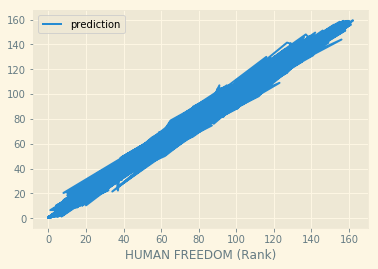

In [31]:
# Convert the Pyspark contructed dataframe to Pandas dataframe to visualize
#Plotting for residuals.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gbt_predictionsPandas = gbt_predictions.toPandas()

plt.style.use('Solarize_Light2')
gbt_predictionsPandas.plot(x="HUMAN FREEDOM (Rank)" ,y='prediction')

In [32]:
gbt_predictions.describe().show()

+-------+--------------------+-------------------+
|summary|HUMAN FREEDOM (Rank)|         prediction|
+-------+--------------------+-------------------+
|  count|                1569|               1569|
|   mean|   75.75780752071383|  75.75780752071373|
| stddev|   45.59914326627794|  45.55832739546484|
|    min|                   0|0.22200398957772965|
|    max|                 162|  159.4400136321508|
+-------+--------------------+-------------------+



In [33]:
# Gradient-boosted Tree Regression on train and test data (split data)---I2

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'HUMAN FREEDOM (Rank)', maxIter=15)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'HUMAN FREEDOM (Rank)', 'features').show(11)

+------------------+--------------------+--------------------+
|        prediction|HUMAN FREEDOM (Rank)|            features|
+------------------+--------------------+--------------------+
|0.5777113775927617|                   0|(31,[0,2,4,9,12,1...|
|0.5777113775927617|                   0|(31,[0,2,4,9,12,1...|
|0.5777113775927617|                   0|(31,[0,2,4,9,12,1...|
|0.5777113775927617|                   0|(31,[0,2,4,9,12,1...|
|0.5777113775927617|                   0|(31,[0,2,4,9,12,1...|
|0.5777113775927617|                   0|(31,[0,2,4,9,12,1...|
|125.27382504056125|                 128|[2008.0,3.58,9.48...|
|115.04114028208976|                 104|[2008.0,4.1,8.868...|
| 75.35710470733295|                  74|[2008.0,4.26,10.0...|
| 90.13390197105926|                  97|[2008.0,4.3,7.321...|
| 91.28623214838665|                  95|[2008.0,4.4,10.0,...|
+------------------+--------------------+--------------------+
only showing top 11 rows



In [34]:
# Root Mean Squared Error (RMSE)
gbt_evaluator_RMSE = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="rmse")
grmse = gbt_evaluator_RMSE.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) = %g" % grmse)

# Mean Absolute Error (MAE)
gbt_evaluator_MAE = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="mae")
gmae = gbt_evaluator_MAE.evaluate(gbt_predictions)
print("Mean Absolute Error (MAE) = %g" % gmae)

# R Squarred (R2)
gbt_evaluator_R2 = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="r2")
gr2 = gbt_evaluator_R2.evaluate(gbt_predictions)
print("R Squarred (R2) = %g" % gr2)

Root Mean Squared Error (RMSE) = 6.29858
Mean Absolute Error (MAE) = 4.59574
R Squarred (R2) = 0.981071


In [35]:
# Gradient-boosted Tree Regression on train and test data (split data)---I3

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'HUMAN FREEDOM (Rank)', maxIter=20)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'HUMAN FREEDOM (Rank)', 'features').show(11)

# Root Mean Squared Error (RMSE)
gbt_evaluator_RMSE = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="rmse")
grmse = gbt_evaluator_RMSE.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) = %g" % grmse)

# Mean Absolute Error (MAE)
gbt_evaluator_MAE = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="mae")
gmae = gbt_evaluator_MAE.evaluate(gbt_predictions)
print("Mean Absolute Error (MAE) = %g" % gmae)

# R Squarred (R2)
gbt_evaluator_R2 = RegressionEvaluator(
    labelCol="HUMAN FREEDOM (Rank)", predictionCol="prediction", metricName="r2")
gr2 = gbt_evaluator_R2.evaluate(gbt_predictions)
print("R Squarred (R2) = %g" % gr2)

+-------------------+--------------------+--------------------+
|         prediction|HUMAN FREEDOM (Rank)|            features|
+-------------------+--------------------+--------------------+
|0.41406482231579433|                   0|(31,[0,2,4,9,12,1...|
|0.41406482231579433|                   0|(31,[0,2,4,9,12,1...|
|0.41406482231579433|                   0|(31,[0,2,4,9,12,1...|
|0.41406482231579433|                   0|(31,[0,2,4,9,12,1...|
|0.41406482231579433|                   0|(31,[0,2,4,9,12,1...|
|0.41406482231579433|                   0|(31,[0,2,4,9,12,1...|
| 125.39453111072265|                 128|[2008.0,3.58,9.48...|
| 114.47490317611391|                 104|[2008.0,4.1,8.868...|
|  74.91333362787948|                  74|[2008.0,4.26,10.0...|
|  89.78398531238139|                  97|[2008.0,4.3,7.321...|
|  91.41697535483442|                  95|[2008.0,4.4,10.0,...|
+-------------------+--------------------+--------------------+
only showing top 11 rows

Root Mean Squa